In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Activation
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

2025-01-16 01:07:55.104310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

class SaveImages(tf.keras.callbacks.Callback):
  def __init__(self, noise, margin, num_rows, num_cols, **kwargs):
    super(tf.keras.callbacks.Callback,self).__init__(**kwargs)
    self.noise = noise
    self.margin = margin
    self.num_rows = num_rows
    self.num_cols = num_cols

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 20 != 0:
      return None

    image_array = np.full((
      self.margin + (self.num_rows * (28 + self.margin)),
      self.margin + (self.num_cols * (28 + self.margin)), 3),
      255, dtype=np.uint8)

    generated_images = self.model.generator.predict(self.noise, verbose=0)
    generated_images = (generated_images + 1.0) * 127.5
    
    image_count = 0
    for row in range(self.num_rows):
      for col in range(self.num_cols):
        r = row * (28 + 16) + self.margin
        c = col * (28 + 16) + self.margin
        image_array[r:r + 28, c:c + 28] = generated_images[image_count]
        image_count += 1

    output_path = 'epoch_images'
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    filename = os.path.join(output_path, f"{epoch}-train.png")
    im = Image.fromarray(image_array)
    im.save(filename)

In [3]:
def Generator(seed_size):
  input = Input(shape=(seed_size,))

  x = Dense(7 * 7 * 256)(input) # 100 -> 7x7x256 = 12544
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Reshape((7, 7, 256))(x) # 12544 -> 7x7x256

  x = Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding="same")(x) # 7x7x256 -> 7x7x128
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding="same")(x) # 7x7x128 -> 14x14x64
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding="same")(x) # 14x14x64 -> 28x28x1
  output = Activation("tanh")(x) # [-1, 1]

  return Model(input, output, name="Generator")

def Critic(image_shape):
  input = Input(shape=image_shape)

  x = Conv2D(64, (5, 5), strides=(2, 2), padding="same")(input)  # 28x28x1 -> 14x14x64
  x = LeakyReLU()(x)
  x = Dropout(0.3)(x)

  x = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same")(x) # 14x14x64 -> 7x7x128
  x = LeakyReLU()(x)
  x = Dropout(0.3)(x)

  x = Flatten()(x) # 7x7x128 -> 6272

  output = Dense(1)(x) # 6272 -> 1

  return Model(input, output, name="Critic")

In [4]:
# Custom WGAN Model
class WGAN(tf.keras.Model):
  def __init__(self, generator, critic, seed_size, critic_extra_steps=5):
    super(WGAN, self).__init__()
    self.generator = generator
    self.critic = critic
    self.seed_size = seed_size
    self.critic_extra_steps = critic_extra_steps

    self.generator_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
    self.critic_loss_tracker = tf.keras.metrics.Mean(name="critic_loss")

  def compile(self, generator_optimizer, critic_optimizer, critic_loss_fn, generator_loss_fn):
    super(WGAN, self).compile()
    self.generator_optimizer = generator_optimizer
    self.critic_optimizer = critic_optimizer
    self.critic_loss_fn = critic_loss_fn
    self.generator_loss_fn = generator_loss_fn

  @property
  def metrics(self):
    return [
      self.generator_loss_tracker,
      self.critic_loss_tracker
    ]

  @tf.function
  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]

    for _ in range(self.critic_extra_steps):
      noise = tf.random.normal(shape=(batch_size, self.seed_size))

      with tf.GradientTape() as critic_tape:
        fake_images = self.generator(noise, training=True)

        real_logits = self.critic(real_images, training = True)
        fake_logits = self.critic(fake_images, training = True) 
        critic_loss = self.critic_loss_fn(real_logits, fake_logits)

      critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
      self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

      for weights in self.critic.trainable_variables:
        weights.assign(tf.clip_by_value(weights, -0.01, 0.01))

    noise = tf.random.normal(shape=(batch_size, self.seed_size))
    with tf.GradientTape() as generator_tape:
      fake_images = self.generator(noise, training = True)
      fake_logits = self.critic(fake_images, training = True) 
      generator_loss = self.generator_loss_fn(fake_logits)

    generator_grad = generator_tape.gradient(generator_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(generator_grad, self.generator.trainable_variables))

    self.generator_loss_tracker.update_state(generator_loss)
    self.critic_loss_tracker.update_state(critic_loss)

    return {
      "generator_loss": self.generator_loss_tracker.result(),
      "critic_loss": self.critic_loss_tracker.result()
    }


  @tf.function
  def test_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal(shape=(batch_size, self.seed_size))

    fake_images = self.generator(noise, training = False)

    real_logits = self.critic(real_images, training = False)
    fake_logits = self.critic(fake_images, training = False) 

    critic_loss = self.critic_loss_fn(real_logits, fake_logits)
    generator_loss = self.generator_loss_fn(fake_logits)

    self.generator_loss_tracker.update_state(generator_loss)
    self.critic_loss_tracker.update_state(critic_loss)

    return {
      "generator_loss": self.generator_loss_tracker.result(),
      "critic_loss": self.critic_loss_tracker.result()
    }

  @tf.function 
  def call(self, inputs):
    image  = self.generator(inputs, training=False)
    score = self.critic(image, training=False)

    return image, score

In [5]:
# Constants
IMAGE_SHAPE = (28, 28, 1)
BATCH_SIZE = 100
EPOCHS = 25
SEED_SIZE = 100

CALLBACK_NUM_ROWS = 4
CALLBACK_NUM_COLS = 7
CALLBACK_MARGIN = 16

CALLBACK_FIXED_SEED = tf.random.normal(shape=(CALLBACK_NUM_ROWS * CALLBACK_NUM_COLS, SEED_SIZE))
IMAGE_FIXED_SEED = tf.random.normal(shape=(10, SEED_SIZE))

GAN_WEIGHTS_PATH = "mnist_wgan.weights.h5"
GAN_LOG_PATH = "mnist_wgan.log"

In [6]:
# Load and preprocess MNIST data
(x_train, _), (_, _) = mnist.load_data()

train_ds = x_train[:50000] # Train on 50,000 examples
val_ds = x_train[50000:] # Validate on 10,000 examples

TRAIN_BUFFER_SIZE = train_ds.shape[0]
VAL_BUFFER_SIZE = val_ds.shape[0]

train_ds = train_ds.reshape(train_ds.shape[0], 28, 28, 1).astype("float32")
val_ds = val_ds.reshape(val_ds.shape[0], 28, 28, 1).astype("float32")

train_ds = (train_ds / 127.5) - 1.0
val_ds = (val_ds / 127.5) - 1.0

train_ds = tf.data.Dataset.from_tensor_slices(train_ds).shuffle(TRAIN_BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds).shuffle(VAL_BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
# Build generator and critic
generator = Generator(SEED_SIZE)
critic = Critic(IMAGE_SHAPE)

generator.build(input_shape=(None, SEED_SIZE))
critic.build(input_shape=(None, 28, 28, 1))

wgan = WGAN(generator, critic, SEED_SIZE)
wgan.build(input_shape=(None, SEED_SIZE))

# load weights if file exists
if tf.io.gfile.exists(GAN_WEIGHTS_PATH):
  wgan.load_weights(GAN_WEIGHTS_PATH)
  print("Loaded weights from file")

def critic_loss(real_images, fake_images):
  real_loss = tf.reduce_mean(real_images)
  fake_loss = tf.reduce_mean(fake_images)
  return fake_loss - real_loss

def generator_loss(fake_images):
  return -tf.reduce_mean(fake_images)

wgan.compile(
  generator_optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-5),
  critic_optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-5),
  critic_loss_fn=critic_loss,
  generator_loss_fn=generator_loss
)

wgan.summary()
wgan.generator.summary()
wgan.critic.summary()

Loaded weights from file


Model: "wgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Generator (Functional)          │ (None, 28, 28, 1)      │     2,343,681 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Critic (Functional)             │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,556,546 (9.75 MB)

 Trainable params: 2,531,074 (9.66 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,343,681 (8.94 MB)

 Trainable params: 2,318,209 (8.84 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "Critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the WGAN model
# wgan.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=201,
#   batch_size=BATCH_SIZE,
#   initial_epoch=0, # should be last_epoch_saved + 1 or 0 of no weights saved
#   callbacks=[
#     CSVLogger(GAN_LOG_PATH, append=True),
#     ModelCheckpoint(GAN_WEIGHTS_PATH, monitor="generator_loss", mode='min', save_weights_only=True),
#     SaveImages(noise=CALLBACK_FIXED_SEED, num_rows=CALLBACK_NUM_ROWS, num_cols=CALLBACK_NUM_COLS, margin=CALLBACK_MARGIN)
#   ]
# )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


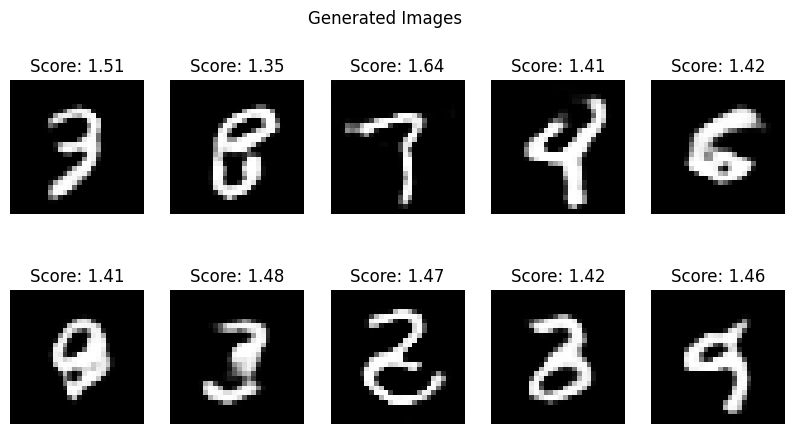

In [9]:
image, score = wgan.predict(IMAGE_FIXED_SEED)

# show 10 images with the critic scores
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Generated Images")
for i in range(10):
  row = i // 5
  col = i % 5
  axs[row, col].imshow((image[i, :, :, 0] + 1.0) * 127.5, cmap="gray")
  axs[row, col].axis("off")
  axs[row, col].set_title(f"Score: {score[i][0]:.2f}")

Text(0.5, 1.0, 'Validation Loss')

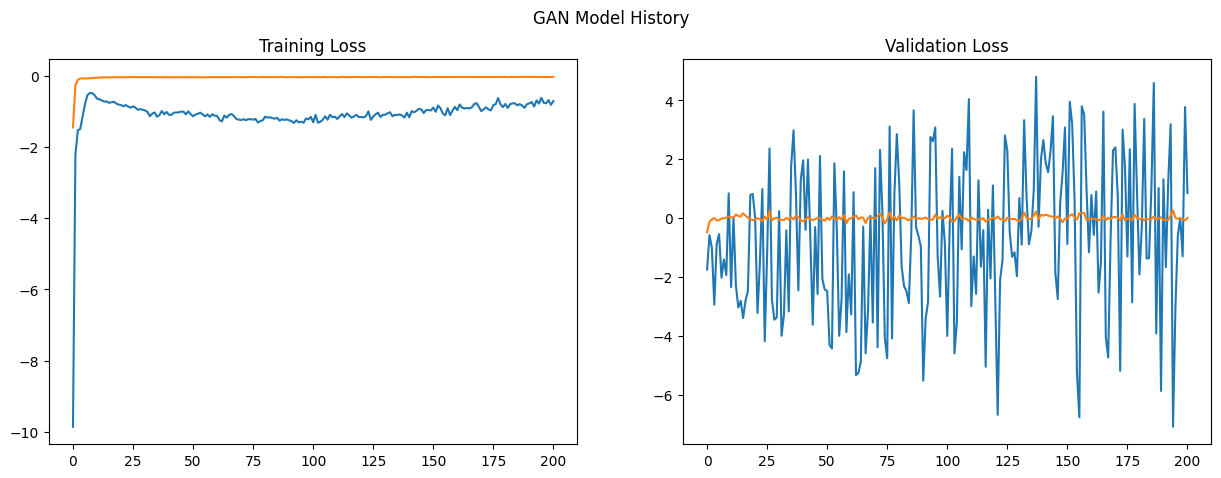

In [10]:
# plot history of the model on graph
import pandas as pd

df = pd.read_csv(GAN_LOG_PATH)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("GAN Model History")
axs[0].plot(df["generator_loss"], label="generator_loss")
axs[0].plot(df["critic_loss"], label="critic_loss")
axs[0].set_title("Training Loss")

axs[1].plot(df["val_generator_loss"], label="val_generator_loss")
axs[1].plot(df["val_critic_loss"], label="val_critic_loss")
axs[1].set_title("Validation Loss")